In [1]:
using CairoMakie
using ProgressMeter
using Random
using Statistics

## Create Lattice Points

In [2]:
N = 10
L = 1.0
box_length = [N*L,N*L]

x = collect(0:(N-1))*L

lattice = [[x_i, y_i] for x_i in x for y_i in x];
lattice = permutedims(stack(lattice));

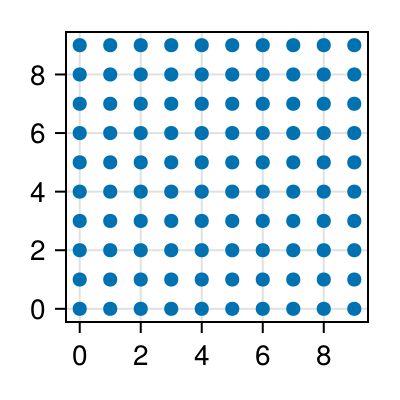

In [3]:
f = Figure(size=(200,200))
ax = Axis(f[1, 1])

scatter!(ax, lattice[:,1], lattice[:,2], 
    markersize=10,legend=false)
f

## Functions to create Spins

In [4]:
struct spin_struct

    centers
    directions

end

function norm_array(x)
    return x./sqrt.(sum(x.^2, dims=2))
end

function create_spins(lattice, pos_basis, dir_basis)
    
    centers = permutedims(stack(
            [lattice[i,:].+pos_basis[j,:] 
                for i in 1:size(lattice,1) 
                    for j in 1:size(pos_basis,1)]));
    
    directions = permutedims(stack(
            [dir_basis[j,[1,2]] 
                for i in 1:size(lattice,1) 
                    for j in 1:size(dir_basis,1)]));
    
    directions = norm_array(directions);
    
    s = spin_struct(centers, directions)

    return s
end

pos_basis = permutedims(stack([[0,1/2],[1/2,0]]))
dir_basis = permutedims(stack([[0,1/2],[1/2,0]]))

spins = create_spins(lattice, pos_basis, dir_basis)

spin_struct([0.0 0.5; 0.5 0.0; … ; 9.0 9.5; 9.5 9.0], [0.0 1.0; 1.0 0.0; … ; 0.0 1.0; 1.0 0.0])

In [5]:
function plot_spins(ax, spins)
    
    sc = 0.6
    st = spins.centers-(spins.directions/2).*sc
    
    arrows!(ax, st[:,1], st[:,2], spins.directions[:,1].*sc, spins.directions[:,2].*sc,
        legend=false)
    
end

plot_spins (generic function with 1 method)

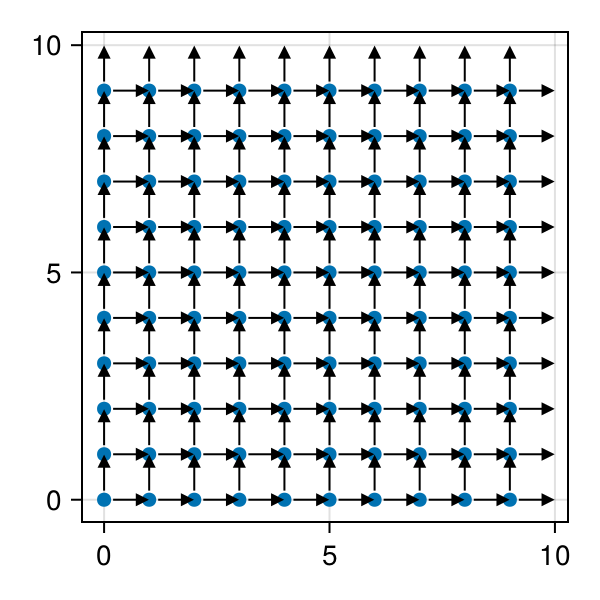

In [6]:
f = Figure(size=(300,300))
ax = Axis(f[1, 1])

scatter!(ax, lattice[:,1], lattice[:,2], 
    markersize=10,legend=false)

plot_spins(ax, spins)
    
f

## Functions to create vertices, and link to spins

In [7]:
function periodic_distance(dist, box_length)
    
    dist_cand = stack([dist-box_length, dist, dist+box_length])
    d_i = [argmin(abs.(dist_cand[i,:])) for i in 1:size(dist_cand,1)]
    return [dist_cand[i,d_i[i]] for i in 1:size(dist_cand,1)]     
    
end

function dist_criterion(i, j, spins, lattice, crit_dist, box_length)

    spin_pos = spins.centers[i,:]
    vert_pos = lattice[j,:]

    dist = spin_pos-vert_pos
    
    per_dist = periodic_distance(dist, box_length)
    
    belongs = sqrt(sum(per_dist.^2))<=crit_dist

    return belongs

end

struct vertex_struct
    
    centers
    spins # to which vertex a spin belongs
    vertices # which spins belong to a vertex
    coordination
    charge
    dipole

    vertex_struct(centers, spins, vertices, coordination, charge, dipole) = 
        new(centers, spins, vertices, coordination, charge, dipole)
    
    vertex_struct(centers, spins, vertices) = 
        new(centers, spins, vertices,
        [length(v_i) for v_i in centers], 
        [0.0 for v_i in centers[:,1]],
        permutedims(stack([[0.0, 0.0] for v_i in centers[:,1]])))



end

function vertices_assign(spins, lattice, criterion)

    centers = lattice
    spins_l = [[] for s in spins.centers[:,1]]
    vertices = [[] for s in lattice[:,1]]
    
    for i in 1:size(spins.centers,1)
        for j in 1:size(lattice,1)
            if criterion(i, j, spins, lattice)
                push!(spins_l[i], j)
                push!(vertices[j], i)
            end
        end
    end
    
    return vertex_struct(centers, spins_l, vertices)
end

vertices = vertices_assign(spins, lattice, 
    (i,j, spins, lattice)->dist_criterion(i,j, spins, lattice, 0.7, box_length));

function spin_contrib(i, spins, vertices, box_length)
    
    link = vertices.centers[vertices.spins[i],:]
    link = link[1,:]-link[2,:]

    link = periodic_distance(link, box_length)
    
    if sum(spins.directions[i,:].*link)>0
        
        return vertices.spins[i]

    else
        return vertices.spins[i][[2,1]]
    end

end

function get_charge(vertices, spins, box_length)

    
    for i in 1:size(vertices.charge,1)
        vertices.charge[i] = 0
    end
    
    for i in 1:size(vertices.spins,1)
        
        sp_dir = spin_contrib(i, spins, vertices, box_length)
        vertices.charge[sp_dir[1]]+=1
        vertices.charge[sp_dir[2]]-=1
        
    end
    
end

function get_dipole(vertices, spins, box_length)
    
    for i in 1:size(vertices.vertices,1)
        for j in 1:size(vertices.vertices[i],1)
            vertices.dipole[i,:]+=spins.directions[j,:]
        end
        vertices.dipole[i,:] = norm_array(vertices.dipole[i,:])
    end
end 


vertices = vertices_assign(spins, lattice, 
    (i,j, spins, lattice)->dist_criterion(i,j, spins, lattice, 0.7, box_length));

get_charge(vertices, spins, box_length)
get_dipole(vertices, spins, box_length)

## Monte Carlo method

In [8]:
function spin_flip(spins, rng)
    M = size(spins.centers,1)
    i = rand(rng, 1:M)
    spins.directions[i,:] = -spins.directions[i,:]
    return i
end

function plot_vertices(ax, vertices)
    
    st = vertices.centers
    
    scatter!(ax, st[:,1], st[:,2], color = -vertices.charge, colormap = :redsblues, 
        legend=false)
    
end

function order_parameter(vertices)
    return -abs(sum(vertices.charge.*(-1).^(sum(vertices.centers/L, dims=2))))
end

order_parameter (generic function with 1 method)

In [9]:
Base.copy(x::spin_struct) = spin_struct([deepcopy(getfield(x, k)) for k in fieldnames(spin_struct)]...)
Base.copy(x::vertex_struct) = vertex_struct([deepcopy(getfield(x, k)) for k in fieldnames(vertex_struct)]...)

In [10]:
N = 10
L = 1.0
box_length = [N*L,N*L]

x = collect(0:(N-1))*L

lattice = [[x_i, y_i] for x_i in x for y_i in x];
lattice = permutedims(stack(lattice));

pos_basis = permutedims(stack([[0,1/2],[1/2,0]]))
dir_basis = permutedims(stack([[0,1/2],[1/2,0]]))

spins = create_spins(lattice, pos_basis, dir_basis)

vertices = vertices_assign(spins, lattice, 
    (i,j, spins, lattice)->dist_criterion(i,j, spins, lattice, 0.7, box_length));

get_charge(vertices, spins, box_length)
get_dipole(vertices, spins, box_length)

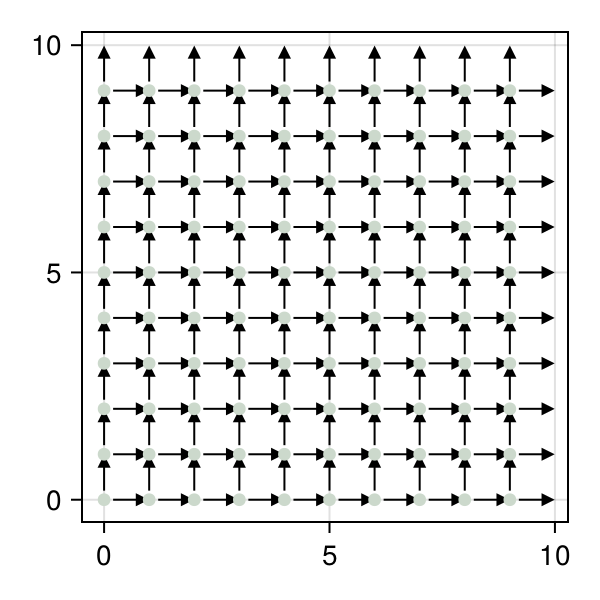

In [11]:
q = sum(abs.(vertices.charge))

spins_new = copy(spins)
vertices_new = copy(vertices)

f = Figure(size=(300,300))
ax = Axis(f[1, 1])

plot_spins(ax, spins)
plot_vertices(ax, vertices)

f

In [12]:
function test(rng, kBT, χ, spins_new, spins, vertices_new, vertices, box_length)
    
    i = spin_flip(spins_new, rng)
    
    get_charge(vertices_new, spins_new, box_length)

    χ_new = order_parameter(vertices_new)

    Δ = χ_new-χ
    
    flip = false
    
    if (Δ<0) || (rand(rng)<exp(-Δ/kBT))
        
        spins.directions[i] = -1.0 * spins.directions[i]
        
        for i in 1:size(vertices.charge,1) 
            vertices.charge[i] = vertices_new.charge[i]
        end

        χ = χ_new

        flip = true        
    end
    
    return flip, Δ, χ
end

test (generic function with 1 method)

In [19]:
χ = order_parameter(vertices)

N = 1000000
kBT = 16 .* (1.0 .- 1.0 .*collect(1:N)/N)

rng = Xoshiro(1234);

flips = zeros(N)
deltas = zeros(N)
χ = zeros(N+1)
χ[1] = 0

@showprogress for i in 1:N

    (flips[i],deltas[i], χ[i+1]) = test(rng, kBT[i], χ[i],
        spins_new, spins,
        vertices_new, vertices,
        box_length)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:02m


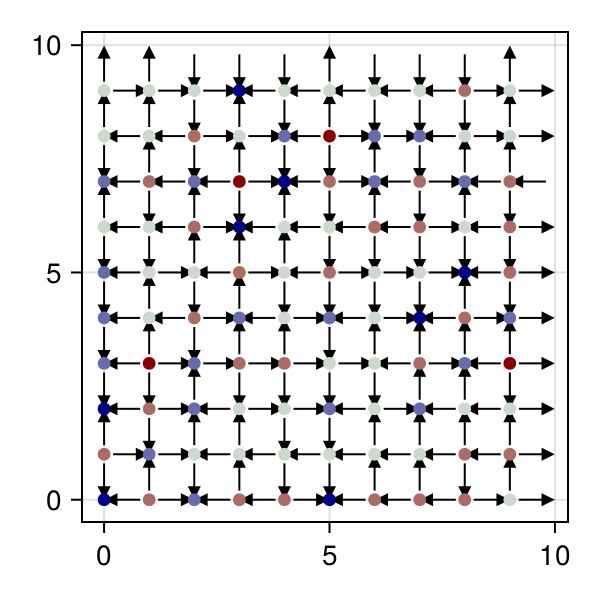

In [20]:
f = Figure(size=(300,300))
ax = Axis(f[1, 1])

plot_spins(ax, spins_new)
plot_vertices(ax, vertices_new)

f

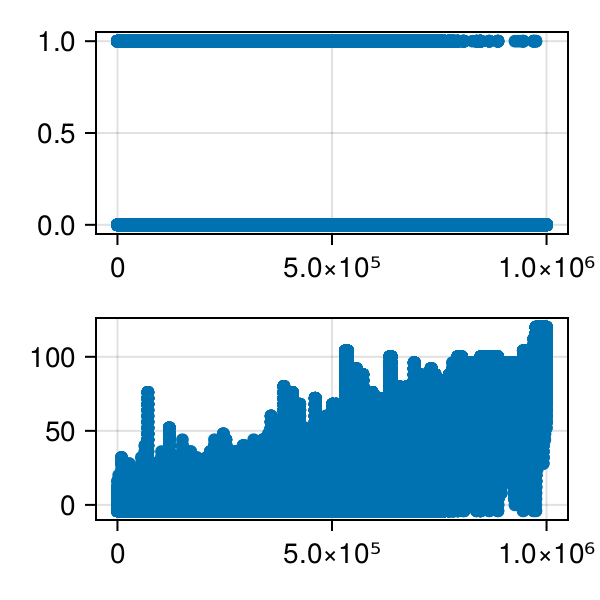

In [21]:
f = Figure(size=(300,300))
ax = [Axis(f[i, 1]) for i in 1:2]

plot!(ax[1], flips)
plot!(ax[2], deltas)
f

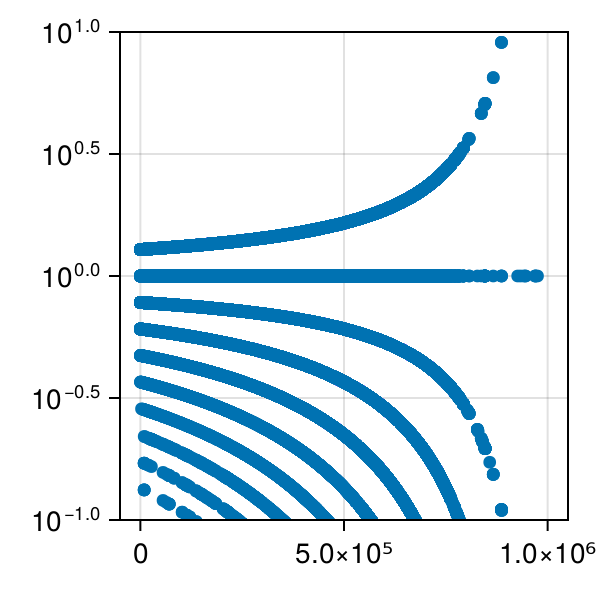

In [22]:
f = Figure(size=(300,300))

ax = Axis(f[1,1], yscale=log10)
ylims!(ax,[0.1,10.0])

plot!(ax, exp.(-deltas./kBT))
f

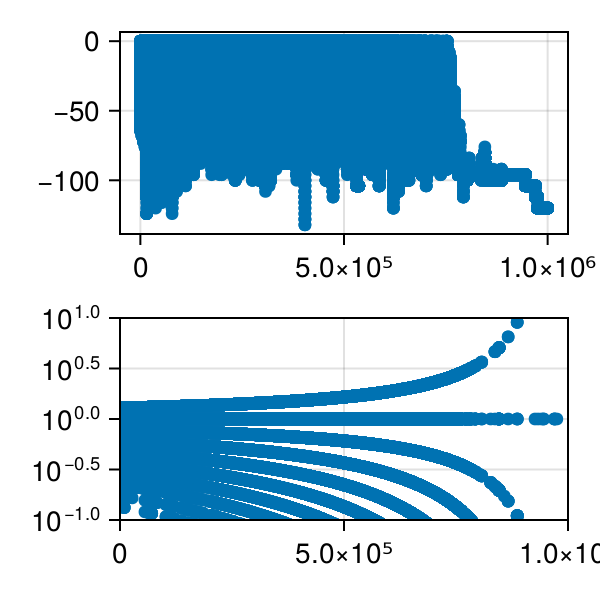

In [23]:
f = Figure(size=(300,300))

ax = [Axis(f[1, 1]),Axis(f[2, 1], yscale=log10)]
ylims!(ax[2],[0.1,10])
xlims!(ax[2],[0,10^6])

plot!(ax[1], χ)
plot!(ax[2], exp.(-deltas./kBT))
f

In [24]:
χ

1000001-element Vector{Float64}:
    0.0
   -4.0
   -8.0
  -12.0
  -16.0
  -12.0
  -12.0
  -12.0
   -8.0
   -4.0
   -8.0
   -8.0
   -8.0
    ⋮
 -120.0
 -120.0
 -120.0
 -120.0
 -120.0
 -120.0
 -120.0
 -120.0
 -120.0
 -120.0
 -120.0
 -120.0